In [58]:
import pandas as pd
import duckdb
import requests

In [59]:
con = duckdb.connect("data/insurance.duckdb")

In [ ]:
# con.close()

In [66]:
# API Approach didn't work because for some reason, API was only fetching 1000 rows and even after applying paginations (iterations based on limits), 
# 1000 rows were repeated again and again.

# all_data = []
# offset = 0
# limit = 10000
# api_url = 'https://www.fema.gov/api/open/v2/FimaNfipPolicies'
# while True:
#     url = f"{api_url}?$limit={limit}&$offset={offset}"
#     response = requests.get(url)
#     data = response.json()['FimaNfipPolicies']

#     if not data:
#         break
    
#     print([list(i.values()) for i in data])
#     policies  = pd.DataFrame([list(i.values()) for i in data], columns = data[0].keys())

#     all_data.append(policies)
#     offset += limit
#     print(f"Fetched {offset} records...")

In [ ]:

# api_url = 'https://www.fema.gov/api/open/v2/FimaNfipPolicies'
# response = requests.get(api_url)
# json_data = response.json()  # Assumes it's a list of dicts

# policies  = pd.DataFrame([i.values() for i in json_data['FimaNfipPolicies']], columns = json_data['FimaNfipPolicies'][0].keys())


                            ## Another way to fetch data from API endpoint using duckdb

# con.execute(f"""
#     SELECT * FROM read_json_auto('{api_url}')
# """)
# con.fetch_df()['FimaNfipPolicies']


# # Insert into DuckDB
con.execute("""
        CREATE TABLE policies as 
        from read_parquet('data\FimaNfipPolicies.parquet')
            """)

In [3]:
con.sql("""
        select count(*) as num_records from policies
        """)

┌─────────────┐
│ num_records │
│    int64    │
├─────────────┤
│    69489458 │
└─────────────┘

In [ ]:
con.execute("""
        CREATE TABLE claims as 
        from read_parquet('data\FimaNfipClaims.parquet')
            """)

In [28]:
con.sql("""
        describe policies
        """)

┌─────────────────────────────────┬──────────────┬─────────┬─────────┬─────────┬─────────┐
│           column_name           │ column_type  │  null   │   key   │ default │  extra  │
│             varchar             │   varchar    │ varchar │ varchar │ varchar │ varchar │
├─────────────────────────────────┼──────────────┼─────────┼─────────┼─────────┼─────────┤
│ agricultureStructureIndicator   │ BOOLEAN      │ YES     │ NULL    │ NULL    │ NULL    │
│ baseFloodElevation              │ DECIMAL(8,2) │ YES     │ NULL    │ NULL    │ NULL    │
│ basementEnclosureCrawlspaceType │ SMALLINT     │ YES     │ NULL    │ NULL    │ NULL    │
│ cancellationDateOfFloodPolicy   │ DATE         │ YES     │ NULL    │ NULL    │ NULL    │
│ condominiumCoverageTypeCode     │ VARCHAR      │ YES     │ NULL    │ NULL    │ NULL    │
│ construction                    │ BOOLEAN      │ YES     │ NULL    │ NULL    │ NULL    │
│ crsClassCode                    │ SMALLINT     │ YES     │ NULL    │ NULL    │ NULL    │

In [25]:
policy_cols, claims_cols = con.sql("""
        describe policies
        """).df().column_name.values, con.sql("""
        describe claims
        """).df().column_name.values

print(list(set(policy_cols)&set(claims_cols)))

['smallBusinessIndicatorBuilding', 'reportedZipCode', 'locationOfContents', 'elevationCertificateIndicator', 'basementEnclosureCrawlspaceType', 'elevationDifference', 'occupancyType', 'floodZoneCurrent', 'elevatedBuildingIndicator', 'stateOwnedIndicator', 'latitude', 'censusTract', 'floodproofedIndicator', 'lowestFloorElevation', 'censusBlockGroupFips', 'countyCode', 'reportedCity', 'contentsDeductibleCode', 'postFIRMConstructionIndicator', 'totalBuildingInsuranceCoverage', 'lowestAdjacentGrade', 'buildingDeductibleCode', 'buildingDescriptionCode', 'agricultureStructureIndicator', 'nonProfitIndicator', 'originalNBDate', 'buildingReplacementCost', 'condominiumCoverageTypeCode', 'longitude', 'originalConstructionDate', 'primaryResidenceIndicator', 'ratedFloodZone', 'nfipRatedCommunityNumber', 'obstructionType', 'nfipCommunityNumberCurrent', 'nfipCommunityName', 'id', 'rateMethod', 'policyCount', 'totalContentsInsuranceCoverage', 'rentalPropertyIndicator', 'baseFloodElevation']


In [37]:
con.sql("""
        select min(originalNBDate), max(originalNBDate) 
        from policies
        """), con.sql("""
        select min(originalNBDate), max(originalNBDate) 
        from claims
        """)

(┌─────────────────────┬─────────────────────┐
 │ min(originalNBDate) │ max(originalNBDate) │
 │        date         │        date         │
 ├─────────────────────┼─────────────────────┤
 │ 0001-01-01          │ 2033-03-25          │
 └─────────────────────┴─────────────────────┘,
 ┌─────────────────────┬─────────────────────┐
 │ min(originalNBDate) │ max(originalNBDate) │
 │        date         │        date         │
 ├─────────────────────┼─────────────────────┤
 │ 0998-09-21          │ 2025-06-10          │
 └─────────────────────┴─────────────────────┘)

In [4]:
# con.sql("""
#         select * from policies as p
#         inner join claims as c on
#         c.latitude = p.latitude and c.longitude = p.longitude 
#         """)
policies_claims = con.sql("""
        select p.recordsPerloc_P, c.recordsPerloc_c, p.lat, p.lon, p.Total_policycount  from
        (select count(*) as recordsPerloc_P, latitude as lat, longitude as lon, sum(policyCount) as Total_policycount
        from policies
        group by latitude, longitude)  as p
        left join 
        (select count(*) as recordsPerloc_c, latitude as lat, longitude as lon
        from claims
        group by latitude, longitude)  as c
        on p.lat=c.lat and p.lon = c.lon
        order by recordsPerloc_P
        """).df()

In [5]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
geometry = gpd.points_from_xy(x = policies_claims['lon'],y=policies_claims['lat'])
policies_claims['diff_CP']  = policies_claims['recordsPerloc_P'] - policies_claims['recordsPerloc_c']
CP_gdf = gpd.GeoDataFrame(policies_claims,geometry = geometry, crs= 'epsg:4326')

Text(0.5, 1.0, 'Likely underinsured locations')

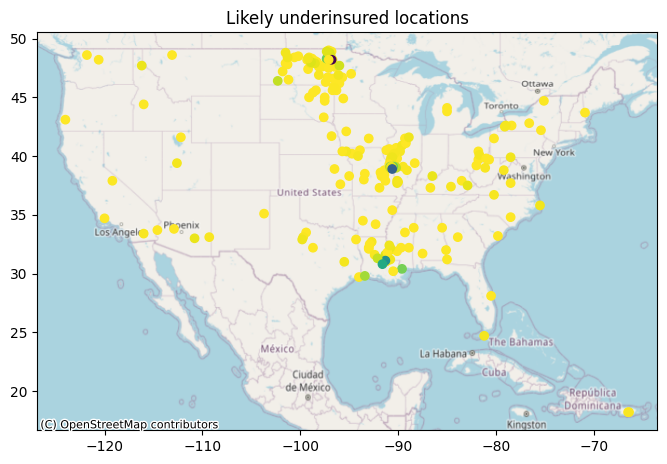

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(8, 14))
CP_gdf[CP_gdf['diff_CP']<0].plot(column = 'diff_CP',ax=ax)
ctx.add_basemap(ax, crs=CP_gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
plt.title('Likely underinsured locations')

In [6]:
zipcode_boundaries = gpd.read_file(r"D:\Self projects\Flood Insurance SQL-Python\data\tl_2020_us_zcta510 (1)\tl_2020_us_zcta510.shp")
zipcode_boundaries

,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,43451,43451,B5,G6350,S,63484189,157689,+41.3183193,-083.6150363,"POLYGON ((-83.70873 41.32733, -83.70815 41.327..."
1,43452,43452,B5,G6350,S,121525288,13721740,+41.5202297,-082.9770334,"POLYGON ((-83.08698 41.5378, -83.08256 41.5377..."
2,43456,43456,B5,G6350,S,9320978,1003775,+41.6318300,-082.8393923,"MULTIPOLYGON (((-82.83558 41.71082, -82.83515 ..."
3,43457,43457,B5,G6350,S,48004678,0,+41.2673301,-083.4274872,"POLYGON ((-83.4965 41.25371, -83.48382 41.2537..."
4,43458,43458,B5,G6350,S,2573816,39915,+41.5304461,-083.2133648,"POLYGON ((-83.22229 41.53102, -83.22228 41.532..."
...,...,...,...,...,...,...,...,...,...,...
33139,84044,84044,B5,G6350,S,123283634,69912365,+40.7201095,-112.1549645,"POLYGON ((-112.26022 40.76909, -112.25333 40.7..."
33140,84045,84045,B5,G6350,S,52799628,89968,+40.3364908,-111.9111905,"MULTIPOLYGON (((-111.9242 40.17034, -111.92406..."
33141,84046,84046,B5,G6350,S,333204942,4460752,+40.9207693,-109.8310453,"POLYGON ((-110.00072 40.99745, -110.00036 40.9..."
33142,84047,84047,B5,G6350,S,16172462,0,+40.6152301,-111.8907499,"POLYGON ((-111.92141 40.62772, -111.92134 40.6..."


In [7]:
## Remove regions outside Contiguous US
excluded_prefixes = ['006', '007', '008', '009', '967', '968', '969', '995', '996', '997', '998', '999']
zip_gdf = zipcode_boundaries[~zipcode_boundaries['ZCTA5CE10'].astype(str).str[:3].isin(excluded_prefixes)]

In [8]:
## Aggregate policies within each zip code
zip_policy = zip_gdf .sjoin(CP_gdf, how="left", predicate='intersects')
#Summing policy counts within each zip code in place and then dropping duplicate geometries
zip_policy['policy_count/zipcode'] = zip_policy.groupby('ZCTA5CE10')['Total_policycount'].transform('sum')
zip_policy = zip_policy.drop_duplicates(subset = ['geometry'])

C:\Users\pranj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\geopandas\geodataframe.py:2391: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4269
Right CRS: EPSG:4326

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026


In [9]:
zip_policy['policy_count/zipcode'].describe()

count     32657.000000
mean       2209.864439
std       18603.670165
min           0.000000
25%           0.000000
50%          15.000000
75%         319.000000
max      791458.000000
Name: policy_count/zipcode, dtype: float64

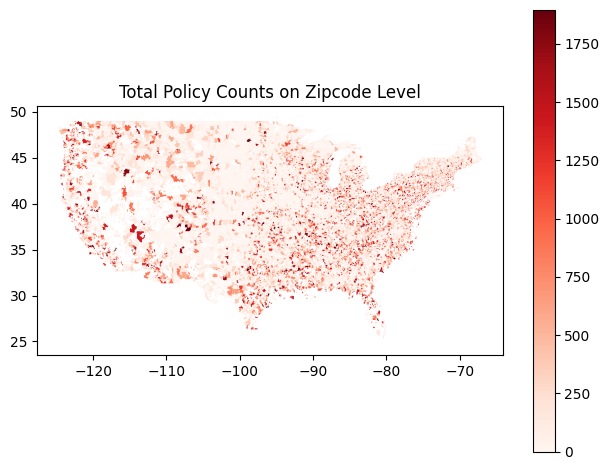

In [21]:
# fig, ax = plt.subplots(1, 1, figsize=(14,8))
zip_policy[zip_policy['policy_count/zipcode']<zip_policy['policy_count/zipcode'].quantile(0.9)].plot(column = 'policy_count/zipcode',cmap = 'Reds',legend=True)
plt.title('Total Policy Counts on Zipcode Level')
plt.tight_layout()

<AxesSubplot: >

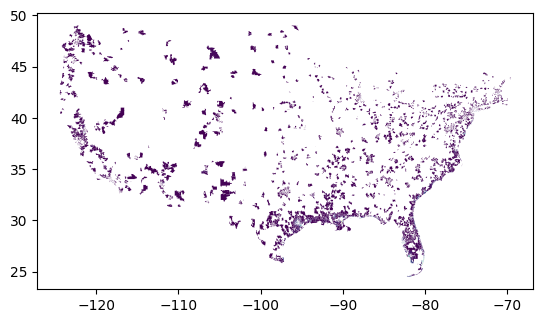

In [16]:
# fig, ax = plt.subplots(1, 1, figsize=(14,8))
zip_policy[zip_policy['policy_count/zipcode']>zip_policy['policy_count/zipcode'].quantile(0.9)].plot(column = 'policy_count/zipcode', cmap = 'viridis')

In [30]:
policy_cols
con.sql("""
       select sum(policyCount), floodZoneCurrent
        from policies 
        group by floodZoneCurrent
        order by sum(policyCount) desc
        """)

┌──────────────────┬──────────────────┐
│ sum(policyCount) │ floodZoneCurrent │
│      int128      │     varchar      │
├──────────────────┼──────────────────┤
│         26021955 │ AE               │
│         25383805 │ NULL             │
│         22485275 │ X                │
│          2558682 │ VE               │
│          1947749 │ AHB              │
│          1937472 │ A                │
│           922353 │ C                │
│           719165 │ AO               │
│           689726 │ AH               │
│           500730 │ AOB              │
│               ·  │  ·               │
│               ·  │  ·               │
│               ·  │  ·               │
│              136 │ V04              │
│               64 │ V03              │
│               51 │ A28              │
│               33 │ A27              │
│               20 │ V23              │
│               11 │ V30              │
│                8 │ A25              │
│                8 │ V24              │


In [31]:
policies_claims_sql = con.sql("""
        select p.recordsPerloc_P, c.recordsPerloc_c, p.lat, p.lon, p.Total_policycount  from
        (select count(*) as recordsPerloc_P, latitude as lat, longitude as lon, sum(policyCount) as Total_policycount
        from policies
        group by latitude, longitude)  as p
        left join 
        (select count(*) as recordsPerloc_c, latitude as lat, longitude as lon
        from claims
        group by latitude, longitude)  as c
        on p.lat=c.lat and p.lon = c.lon
        order by recordsPerloc_P
        """)

In [46]:
flag_underinsured = con.sql("""
        SELECT *,
        CASE 
        WHEN  recordsPerloc_P > recordsPerloc_c OR recordsPerloc_c is NULL
        THEN 'Normal' 
        ELSE 'Anomaly/Underinsured' END AS flag
        from policies_claims_sql
        ORDER BY recordsPerloc_P DESC
        """)
flag_underinsured
        

┌─────────────────┬─────────────────┬──────────────┬──────────────┬───────────────────┬─────────┐
│ recordsPerloc_P │ recordsPerloc_c │     lat      │     lon      │ Total_policycount │  flag   │
│      int64      │      int64      │ decimal(9,1) │ decimal(9,1) │      int128       │ varchar │
├─────────────────┼─────────────────┼──────────────┼──────────────┼───────────────────┼─────────┤
│          747630 │           52225 │         30.0 │        -90.2 │            791458 │ Normal  │
│          744876 │           62089 │         30.0 │        -90.1 │            783700 │ Normal  │
│          582988 │           51771 │         29.9 │        -90.1 │            638124 │ Normal  │
│          534133 │           10528 │         25.7 │        -80.4 │            648027 │ Normal  │
│          402070 │            4875 │         25.9 │        -80.3 │            521573 │ Normal  │
│          401959 │           28596 │         29.9 │        -90.0 │            408496 │ Normal  │
│          393088 │ 

In [56]:
con.sql("""
    Select p.id, p.floodzoneCurrent, p.latitude, p.longitude,p.reportedCity, p.policyCount 
        from policies as p
        inner join claims as c
        on p.id = c.id
    """
)

┌──────┬──────────────────┬──────────────┬──────────────┬──────────────┬─────────────┐
│  id  │ floodZoneCurrent │   latitude   │  longitude   │ reportedCity │ policyCount │
│ uuid │     varchar      │ decimal(9,1) │ decimal(9,1) │   varchar    │    int16    │
├──────┴──────────────────┴──────────────┴──────────────┴──────────────┴─────────────┤
│                                       0 rows                                       │
└────────────────────────────────────────────────────────────────────────────────────┘